# Predictive Analysis of Exchange Rate of US and UK 
## - Can we use Purchasing Power Parity(PPP) Model to predict exchange rate?


The Meese and Rogoff (1983) puzzle suggests that exchange rates are unable to predict since they are approximated by the random walk. This project analyzes the predictive performance for the dollar to pound exchange rate by applying the ARIMA model and purchasing power parity (PPP) model. The results confirm that the exchange rate follows a random walk.

# 1. Get Data: Exchange Rates of US and UK

The data period is from January 1976 to November 2015 with a sum of 479 observations.British pound per dollar nominal exchange rates are obtained from the Federal Reserve Bank of St. Louis Economic Data(FRED). This project uses the United Kingdom as the domestic country, so exchange rates are defined as domestic prices per unit of the dollar, therefore, a rise in exchange rate indicates a depreciation of the British pound. 

**Note:** After handling missing values for the full datasets, it remains 478 observations for prediction models.

In [443]:
import pandas as pd
ex_df = pd.read_excel('https://fred.stlouisfed.org/graph/fredgraph.xls?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=EXUSUK&scale=left&cosd=1976-01-01&coed=2015-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2018-11-30&revision_date=2018-11-30&nd=1971-01-01')
ex_df.head(15)

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fred.stlouisfed.org/help-faq,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
5,NaN,NaN
6,EXUSUK,"U.S. / U.K. Foreign Exchange Rate, U.S. Dollar..."
7,NaN,NaN
8,Frequency: Monthly,NaN
9,observation_date,EXUSUK


In [444]:
#drop unuseful information for regression purpose
ex_df.drop(ex_df.index[:10],inplace=True)
#Rename columns
ex_df = ex_df.rename(columns={'FRED Graph Observations':'Date', 'Unnamed: 1':'EXUSUK'})
#Reformat date
ex_df['Date'] = pd.to_datetime(ex_df['Date'], format = '%Y-%m-%d')
ex_df.head()

,Date,EXUSUK
10,1976-01-01,2.0286
11,1976-02-01,2.0262
12,1976-03-01,1.9428
13,1976-04-01,1.8463
14,1976-05-01,1.8079


In [445]:
#Converting exchange rate data, using UK as domestic country
#so exchange rates are defined as domestic prices per unit of the dollar
#therefore, a rise in exchange rate indicates a depreciation of the British pound.
ex_df['ex'] = 1/ex_df.EXUSUK
ex_df.head()

,Date,EXUSUK,ex
10,1976-01-01,2.0286,0.492951
11,1976-02-01,2.0262,0.493535
12,1976-03-01,1.9428,0.514721
13,1976-04-01,1.8463,0.541624
14,1976-05-01,1.8079,0.553128


In [446]:
import numpy as np
ex_df['log_ex'] = np.log(ex_df['ex'].astype('float'))
#Create lagged logorithm exchange rates
ex_df['laglog_ex'] = ex_df['log_ex'].shift(1)
#Create a new column that represents changes in exchange rates from t = 0 to t = 1.
ex_df['change_logex'] = ex_df['log_ex'].astype('float') - ex_df['laglog_ex'].astype('float')
ex_df.head()

,Date,EXUSUK,ex,log_ex,laglog_ex,change_logex
10,1976-01-01,2.0286,0.492951,-0.707346,NaN,NaN
11,1976-02-01,2.0262,0.493535,-0.706162,-0.707346,0.001184
12,1976-03-01,1.9428,0.514721,-0.664130,-0.706162,0.042032
13,1976-04-01,1.8463,0.541624,-0.613184,-0.664130,0.050947
14,1976-05-01,1.8079,0.553128,-0.592166,-0.613184,0.021018


In [447]:
ex_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 10 to 488
Data columns (total 6 columns):
Date            479 non-null datetime64[ns]
EXUSUK          479 non-null object
ex              479 non-null object
log_ex          479 non-null float64
laglog_ex       478 non-null float64
change_logex    478 non-null float64
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 26.2+ KB


**Note:** Variables laglog_ex and change_logex have missing values. I will deal with it later.

# 2. Load Libraries

In [448]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
import time
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

# 3. Visualize the time series data

### 3.1 Exchange Rates Plots

The first plot below shows the non-stationarity of GBP per dollar exchange rates from Jan 1976 to Nov 2015, and the second plot shows the monthly log exchange rate changes which indicate clustered volatility.

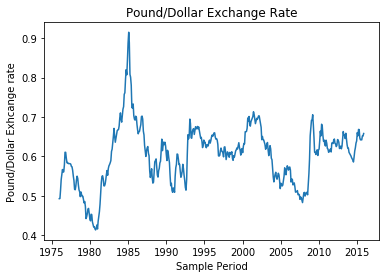

In [449]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

t = ex_df.Date

plt.plot(t,ex_df.ex) 
plt.xlabel('Sample Period')           # X-axis label
plt.ylabel('Pound/Dollar Exhcange rate')              # Y-axis label
plt.title('Pound/Dollar Exchange Rate')
plt.show()

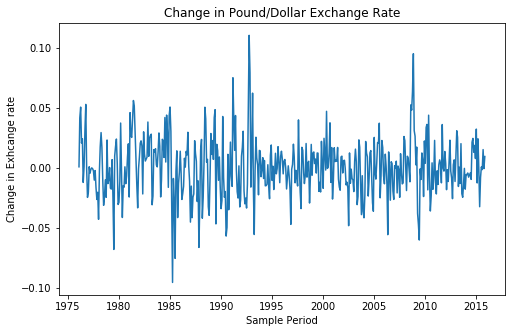

In [450]:
%matplotlib inline
plt.figure(figsize=(8,5))
plt.plot(t,ex_df['change_logex']) 
plt.xlabel('Sample Period')           # X-axis label
plt.ylabel('Change in Exhcange rate')              # Y-axis label
plt.title('Change in Pound/Dollar Exchange Rate')
plt.show()

### 3.2 Change in Exchange Rate Histogram

The below histogram indicates that the log exchange rate changes follow a leptokurtic distribution.

Text(0.5, 1.0, 'Change in Exchange Rate Histogram')

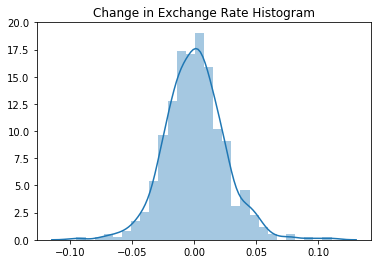

In [451]:
import seaborn as sns

sns.distplot(ex_df['change_logex'].dropna().values)
ax = plt.gca()
ax.set_title("Change in Exchange Rate Histogram")

# 4. Check for Stationarity

In a stationary time series, the parameters of variables must be constant over time and its autocovariance must be independent with time. But we know that the regression in a time series is not time indepedent. Therefore, to apply regression techniques on these variables, we need the data to be stationary.


This project uses the Dickey-Fuller test to check stationarity, the null hypothesis is that the time series is non-stationary. The alternative hypothesis is that the time series is stationary. If the test statistic is less than the critical values, the null hypothesis will be rejected.

**Dickey-Fuller test on the time series:**

In [452]:
def check_stationarity(timeseries):
#Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

In [453]:
check_stationarity(ex_df.ex)

Results of Dickey-Fuller Test:
Test Statistic                  -3.141865
p-value                          0.023606
#Lags Used                       3.000000
Number of Observations Used    475.000000
Critical Value (1%)             -3.444192
Critical Value (5%)             -2.867644
Critical Value (10%)            -2.570021
dtype: float64


**DF Results:** Because the test statistic (-3.14) is less than the 5% critical value and the p-value (0.02) is smaller than 0.05, the moving average is constant over time and we can reject the null hypothesis of the Dickey-Fuller test. This shows that the exchange rate time series is stationary.

# 5. Purchasing Power Parity (PPP) Model
Purchasing Power Parity (PPP) fundamentals also are popularly used to forecast exchange rate. PPP suggests that the real prices of a basket of goods between two countries are the same, i.e. when converting domestic currency to foreign currency at the PPP rate, the same baskets of goods can be bought, which indicates the same price level. Thus, under PPP, we can use the
following equation to forecast exchange rate:

\begin{equation*}
\mathbf{e}_t - \mathbf{e}_{t-1}= a + \beta (\mathbf{CPIUK}_{t-1}-\mathbf{CPIUS}_{t-1}) + \delta_{t}
\end{equation*}


# 5.1 Get Data for PPP Model [Consumer Price Index (CPI) of UK and US]

Data Description:
Monthly variables. The data period is from January 1976 to November 2015 with a sum of 479 observations. Consumer Price Index (CPI) is used to represent price levels.

In [454]:
CPIUK_df = pd.read_excel('https://fred.stlouisfed.org/graph/fredgraph.xls?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GBRCPIALLMINMEI&scale=left&cosd=1976-01-01&coed=2015-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2018-12-03&revision_date=2018-12-03&nd=1960-01-01')
CPIUK_df.head(15)

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fred.stlouisfed.org/help-faq,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
5,NaN,NaN
6,GBRCPIALLMINMEI,Consumer Price Index of All Items in the Unite...
7,NaN,NaN
8,Frequency: Monthly,NaN
9,observation_date,GBRCPIALLMINMEI


In [455]:
#drop unuseful information for regression purpose
CPIUK_df.drop(CPIUK_df.index[:10],inplace=True)
#Rename columns
CPIUK_df = CPIUK_df.rename(columns={'FRED Graph Observations':'Date', 'Unnamed: 1':'CPIUK'})
#Reformat date
CPIUK_df['Date'] = pd.to_datetime(CPIUK_df['Date'], format = '%Y-%m-%d')
CPIUK_df.head()

,Date,CPIUK
10,1976-01-01,17.8615
11,1976-02-01,18.091
12,1976-03-01,18.1876
13,1976-04-01,18.5378
14,1976-05-01,18.7431


In [456]:
CPIUK_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 10 to 488
Data columns (total 2 columns):
Date     479 non-null datetime64[ns]
CPIUK    479 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 11.2+ KB


**Note:** No missing values.

In [457]:
CPIUS_df = pd.read_excel('https://fred.stlouisfed.org/graph/fredgraph.xls?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPALTT01USM661S&scale=left&cosd=1976-01-01&coed=2015-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2018-12-03&revision_date=2018-12-03&nd=1960-01-01')
CPIUS_df.head(15)

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fred.stlouisfed.org/help-faq,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
5,NaN,NaN
6,CPALTT01USM661S,Consumer Price Index: Total All Items for the ...
7,NaN,NaN
8,Frequency: Monthly,NaN
9,observation_date,CPALTT01USM661S


In [458]:
#drop unuseful information for regression purpose
CPIUS_df.drop(CPIUS_df.index[:10],inplace=True)
#Rename columns
CPIUS_df = CPIUS_df.rename(columns={'FRED Graph Observations':'Date', 'Unnamed: 1':'CPIUS'})
#Reformat date
CPIUS_df['Date'] = pd.to_datetime(CPIUS_df['Date'], format = '%Y-%m-%d')
CPIUS_df.head()

,Date,CPIUS
10,1976-01-01,23.5426
11,1976-02-01,23.5848
12,1976-03-01,23.627
13,1976-04-01,23.6692
14,1976-05-01,23.7958


In [459]:
CPIUS_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 10 to 488
Data columns (total 2 columns):
Date     479 non-null datetime64[ns]
CPIUS    479 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 11.2+ KB


**Note:** No missing values.

In [460]:
# merge the two dataframes based on a common column 'Date'
CPI_df = CPIUK_df.merge(CPIUS_df, on=['Date'])
#Merge all datasets
df1 = ex_df.merge(CPI_df, how= 'outer', on=['Date'])
df1.head()

,Date,EXUSUK,ex,log_ex,laglog_ex,change_logex,CPIUK,CPIUS
0,1976-01-01,2.0286,0.492951,-0.707346,NaN,NaN,17.8615,23.5426
1,1976-02-01,2.0262,0.493535,-0.706162,-0.707346,0.001184,18.091,23.5848
2,1976-03-01,1.9428,0.514721,-0.664130,-0.706162,0.042032,18.1876,23.627
3,1976-04-01,1.8463,0.541624,-0.613184,-0.664130,0.050947,18.5378,23.6692
4,1976-05-01,1.8079,0.553128,-0.592166,-0.613184,0.021018,18.7431,23.7958


In [461]:
#Create lagged CPIUS and lagged CPIUK
df1['CPIUK'] = df1['CPIUK'].shift(1)
df1['CPIUS'] = df1['CPIUS'].shift(1)
#Difference of price levels between US and UK
df1['dCPI'] = df1.CPIUK - df1.CPIUS
df1.head()

,Date,EXUSUK,ex,log_ex,laglog_ex,change_logex,CPIUK,CPIUS,dCPI
0,1976-01-01,2.0286,0.492951,-0.707346,NaN,NaN,NaN,NaN,NaN
1,1976-02-01,2.0262,0.493535,-0.706162,-0.707346,0.001184,17.8615,23.5426,-5.68111
2,1976-03-01,1.9428,0.514721,-0.664130,-0.706162,0.042032,18.091,23.5848,-5.49385
3,1976-04-01,1.8463,0.541624,-0.613184,-0.664130,0.050947,18.1876,23.627,-5.43943
4,1976-05-01,1.8079,0.553128,-0.592166,-0.613184,0.021018,18.5378,23.6692,-5.13139


In [462]:
df1.dtypes

Date            datetime64[ns]
EXUSUK                  object
ex                      object
log_ex                 float64
laglog_ex              float64
change_logex           float64
CPIUK                   object
CPIUS                   object
dCPI                    object
dtype: object

### ====>> Convert object to float for regression purposes

In [463]:
df1['EXUSUK'] = pd.to_numeric(df1.EXUSUK, errors='coerce')
df1['ex'] = pd.to_numeric(df1.ex, errors='coerce')
df1['CPIUK'] = pd.to_numeric(df1.CPIUK, errors='coerce')
df1['CPIUS'] = pd.to_numeric(df1.CPIUS, errors='coerce')
df1['dCPI'] = pd.to_numeric(df1.dCPI, errors='coerce')
df1.head()

,Date,EXUSUK,ex,log_ex,laglog_ex,change_logex,CPIUK,CPIUS,dCPI
0,1976-01-01,2.0286,0.492951,-0.707346,NaN,NaN,NaN,NaN,NaN
1,1976-02-01,2.0262,0.493535,-0.706162,-0.707346,0.001184,17.861500,23.542615,-5.681115
2,1976-03-01,1.9428,0.514721,-0.664130,-0.706162,0.042032,18.090958,23.584806,-5.493848
3,1976-04-01,1.8463,0.541624,-0.613184,-0.664130,0.050947,18.187572,23.626997,-5.439425
4,1976-05-01,1.8079,0.553128,-0.592166,-0.613184,0.021018,18.537798,23.669188,-5.131391


In [464]:
df1.dtypes

Date            datetime64[ns]
EXUSUK                 float64
ex                     float64
log_ex                 float64
laglog_ex              float64
change_logex           float64
CPIUK                  float64
CPIUS                  float64
dCPI                   float64
dtype: object

# 6. Handle Missing Values

In [465]:
#Since missing values only appear in the first row, so drop the first row to leave 478 observations.
df1.drop(df1.index[:1],inplace=True)
df1.head()
#So that there are 478 observations now.

,Date,EXUSUK,ex,log_ex,laglog_ex,change_logex,CPIUK,CPIUS,dCPI
1,1976-02-01,2.0262,0.493535,-0.706162,-0.707346,0.001184,17.861500,23.542615,-5.681115
2,1976-03-01,1.9428,0.514721,-0.664130,-0.706162,0.042032,18.090958,23.584806,-5.493848
3,1976-04-01,1.8463,0.541624,-0.613184,-0.664130,0.050947,18.187572,23.626997,-5.439425
4,1976-05-01,1.8079,0.553128,-0.592166,-0.613184,0.021018,18.537798,23.669188,-5.131391
5,1976-06-01,1.7640,0.566893,-0.567584,-0.592166,0.024582,18.743102,23.795761,-5.052659


In [466]:
#double-check whether all variables have the same shape
df1.iloc[476:480,:]

,Date,EXUSUK,ex,log_ex,laglog_ex,change_logex,CPIUK,CPIUS,dCPI
477,2015-10-01,1.5343,0.651763,-0.428074,-0.427748,-0.000326,100.2,100.189860,0.010140
478,2015-11-01,1.5194,0.658155,-0.418316,-0.428074,0.009759,100.3,100.315167,-0.015167


In [468]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 1 to 478
Data columns (total 9 columns):
Date            478 non-null datetime64[ns]
EXUSUK          478 non-null float64
ex              478 non-null float64
log_ex          478 non-null float64
laglog_ex       478 non-null float64
change_logex    478 non-null float64
CPIUK           478 non-null float64
CPIUS           478 non-null float64
dCPI            478 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 37.3 KB


# 7. The Random Walk Benchmark
Forecasting exchange rate has led to some difficult questions in financial and economic empirical studies. Since Meese and Rogoff (1983), it has been prevailing that the out-of-sample forecasting ability of exchange rate when conditioning on macroeconomic variables is extremely poor; in particular, at short horizons, they suggest that the random walk model performs better than other empirical exchange rate models. This project uses the random walk without drift as a benchmark to
compare with other models. For example, when forecast exchange rate with Purchasing Power Parity (PPP) model, the random walk model as specified in equation (1) is the null hypothesis:
\begin{equation*}
\mathbf{e}_t = \mathbf{e}_{t-1} + \mathbf{v}_t
\end{equation*}

By the definition of the random walk without drift, exchange rates follow a martingale difference process, in other words, $E(\mathbf{e}_{t+1}|\mathbf{e}_t, \mathbf{e}_{t-1}, …, \mathbf{e}_0) = \mathbf{e}_t$ for all t; the best prediction of $\mathbf{e}_{t+1}$ is $\mathbf{e}_t$ for all t >= 0. 

# 7.1 Find Optimal Values for an ARIMA Model

To use an ARIMA model, I first need to find optimal parameters of the **ARIMA(p,d,q)**, which contains the following three parameters p,d and q:

**The number of autoregressive (AR) terms (p):** p are lags of the dependent variable which is the exchange rate of US and UK. So, if p=2, it means that predictors of $\mathbf{e}_{t}$ will be $\mathbf{e}_{t-1}$, $\mathbf{e}_{t-2}$.

**The number of moving average (MA) terms (q):** q are lagged forecast errors in the prediction equation. For instance, if q=1, the predictors for $\mathbf{e}_{t}$ will be $\delta_{t-1}$ where $\delta_{i}$ is the difference between the moving average at i-th instant and the actual value.

**The number of differences (d):** d are the number of non-seasonal differences. In my case, d=1, as I am modeling the first difference of time series.

To determine the number of AR and MA terms. I use the **arma_order_select_ic** function in Python:

In [469]:
sm.tsa.arma_order_select_ic(df1['change_logex'].values, max_ar = 4, max_ma = 2, ic='aic')['aic_min_order'] # AIC

(0, 1)

(0,1) represents (p,q). Thus, the order selection results suggest me to choose 0 lag for my dependent variable and 1 lag for forecast errors.

# 7.2 The ARIMA model using the values (0,1,1):

#### Time set the variables

In [471]:
#time set the exchange rate variable for the time series regeression
indexed_df1 = df1.set_index('Date')
ts_ex = indexed_df1['ex']
ts_ex = ts_ex.resample('M').mean()
ts_ex.head()

Date
1976-02-29    0.493535
1976-03-31    0.514721
1976-04-30    0.541624
1976-05-31    0.553128
1976-06-30    0.566893
Freq: M, Name: ex, dtype: float64

In [472]:
indexed_df1 = df1.set_index('Date')
ts_log_ex = indexed_df1['log_ex']
ts_log_ex = ts_log_ex.resample('M').mean()
ts_log_ex.head()

Date
1976-02-29   -0.706162
1976-03-31   -0.664130
1976-04-30   -0.613184
1976-05-31   -0.592166
1976-06-30   -0.567584
Freq: M, Name: log_ex, dtype: float64

In [473]:
indexed_df1 = df1.set_index('Date')
ts_change_logex = indexed_df1['change_logex']
ts_change_logex = ts_change_logex.resample('M').mean()
ts_change_logex.head()

Date
1976-02-29    0.001184
1976-03-31    0.042032
1976-04-30    0.050947
1976-05-31    0.021018
1976-06-30    0.024582
Freq: M, Name: change_logex, dtype: float64

#### Apply The ARIMA model 

In [474]:
model = ARIMA(ts_log_ex, order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.log_ex   No. Observations:                  477
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1128.574
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Dec 2018   AIC                          -2251.148
Time:                        23:46:16   BIC                          -2238.645
Sample:                    03-31-1976   HQIC                         -2246.232
                         - 11-30-2015                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0006      0.001      0.440      0.660      -0.002       0.003
ma.L1.D.log_ex     0.3810      0.042      9.076      0.000       0.299       0.463
                                    

**Notes:** L1.D.change_logex means the variable "change_logex" has 1 lag for the regeression.

**Results:** The significantly large p-value for the constant confirms that the choice of a random walk model without drift(without constant) is better than a random walk model with drift(with a constant) because the constant is not statistically significant(p-value of 0.66 is quite big). 

                0
count  477.000000
mean    -0.000010
std      0.022742
min     -0.081890
25%     -0.014455
50%      0.000171
75%      0.013211
max      0.090342


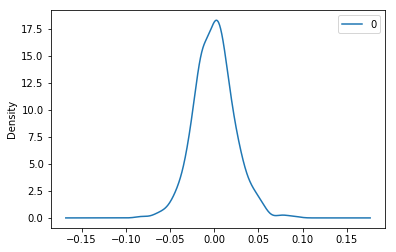

In [475]:
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

# 7.3 Model Validation Check Results
**The model validation checks have confirmed good results because the density plot of the residual errors indicates a normal distribution centered around zero mean. Also, the residuals do not violate the assumptions of constant location and scale with most values in the range (-1,1).** So continue the following scale  prediction:

# 7.4 Scale Predictions
Back to original scale for exchange rate predictions, which requires to remove the first order differencing and take exponent to restore the predictions back to their original scale.
The lower the root mean square error (RMSE) and the closer it is to 0, the better are the model predictions in being closer to actual values.

In [406]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1976-03-31    0.000632
1976-04-30    0.014407
1976-05-31    0.014303
1976-06-30    0.003183
1976-07-31    0.008782
Freq: M, dtype: float64


#### (1) Remove the first order differencing 

In [407]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log_ex.iloc[0], index=ts_log_ex.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

#### (2) Take exponent to restore the predictions back to the original scale

Text(0.5, 1.0, 'RMSE: 0.0657')

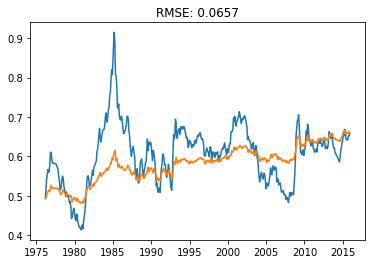

In [408]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_ex.index.to_pydatetime(), ts_ex.values)
plt.plot(ts_ex.index.to_pydatetime(), predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_ex)**2)/len(ts_ex)))

# 7.5 Prediction Results:
The RMSE(0.0657) is pretty small and close to 0, which means the model predictions are quite accurate.

# 8. In-sample Linear Regression Estimates of PPP Model

In [409]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('change_logex ~ dCPI', data = df1).fit()
# print(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           change_logex   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.418
Date:                Thu, 13 Dec 2018   Prob (F-statistic):              0.234
Time:                        22:47:21   Log-Likelihood:                 1099.5
No. Observations:                 478   AIC:                            -2195.
Df Residuals:                     476   BIC:                            -2187.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.406      0.685      -0.002       0.003
dCPI          -0.0005      0.000     -1.191      0.234      -0.001       0.000
==============================================================================
Omnibus:                       27.751   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.589
Skew:                           0.257   Prob(JB):                     1.28e-15
Kurtosis:                       4.783   Cond. No.                         2.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results: The extremely small R-squared and adjusted R-squared indicate that the price level difference actually has little 
explanation power of the exchange rate changes. It shows no strong relationships between explainable variables and the logarithmic changes in exchange rate because all coefficients are not statistically significant.**

# 9. One-Step Out-of-Sample Forecasting (One-Month Horizon)
In order to assess the statistical significance of the forecasting results, **the squared prediction errors (MSPE)** is used, which is calculated by take the average of the mean sqaured(y - predicted_y).
## 9.1 PPP Model

In [476]:
from pyfinance.ols import PandasRollingOLS

y = df1.change_logex
x = df1.dCPI

window = 120  # months
ppp_model = PandasRollingOLS(y=y, x=x, window=window)

In [477]:
predicted_results = pd.DataFrame(ppp_model.predicted)
predicted_results.head()

predicted
end subperiod           
120 1           0.005138
    2           0.005001
    3           0.004961
    4           0.004735
    5           0.004677

In [479]:
MSPE1 = pd.DataFrame(ppp_model.ms_err)
MSPE1.head()

,ms_err
120,0.000722
121,0.000722
122,0.000716
123,0.000701
124,0.000700


In [480]:
MSPE1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 120 to 478
Data columns (total 1 columns):
ms_err    359 non-null float64
dtypes: float64(1)
memory usage: 5.6 KB


In [481]:
#The average of MSPE
MSPE_ppp = MSPE1.mean()
print(MSPE_ppp)

ms_err    0.000616
dtype: float64


## 9.2 the Benchmark Model: Random Walk Model

Recall that by the definition of the random walk without drift, exchange rates follow a martingale difference process, in other words, $E(\mathbf{e}_{t+1}|\mathbf{e}_t, \mathbf{e}_{t-1}, …, \mathbf{e}_0) = \mathbf{e}_t$ for all t; the best prediction of $\mathbf{e}_{t+1}$ is $\mathbf{e}_t$ for all t >= 0. 

Therefore, in my case, the predicted results of change_logex should all be 0.

Thus, to calculate the MSPEs for the random walk model, we need to substract the predicted results from the actual values of change_logex. i.e. MSPEs should be:

In [482]:
MSPE2 = 0 - df1.change_logex
MSPE2.head()

1   -0.001184
2   -0.042032
3   -0.050947
4   -0.021018
5   -0.024582
Name: change_logex, dtype: float64

Therefore, the average of MSPE for the random walk model is:

In [483]:
MSPE_rw = MSPE2.mean()
print(MSPE_rw) 

-0.0006046660666794433


# Conclusion

#### The MSPE of random walk is smaller than the MSPE of the PPP model. The exchange rate follows a random walk, so there is a disconnect between the exchange rate forecasting with the convetional macroeconomic model of the Purchasing Power Parity.

# Reference

Meese, R. and Rogoff, K. (1983). Empirical exchange rate models of the seventies. Journal
   of International Economics, 14(1-2), pp.3-24.